In [110]:
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import linregress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# RC - params . Better plots
def SetPlotParams():
    '''
     Inputs:
     Return:
    '''
    plt.rcParams.update({'font.size': 25})
    plt.rc("text", usetex = True)
    plt.rc("font", family = "serif")
    plt.rcParams['figure.subplot.hspace'] = 0.3
    plt.rcParams['figure.subplot.wspace'] = 0.1
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['axes.formatter.limits'] = -3 , 3
    plt.rc('xtick.major', pad = 1)
    plt.rc('ytick.major', pad = 1)
    plt.rcParams['axes.labelpad'] = 15
    plt.rcParams['axes.formatter.use_mathtext'] = False
    plt.rcParams['figure.autolayout'] = True
    # plt.rcParams['figure.figsize'] =  8.3, 6.8
    plt.rcParams['figure.figsize'] =  6.8, 8.3
# %%
SetPlotParams()


### List of Constants

In [111]:
## List of Constants



"""Parameters, units: ueV, nm, ns"""
print('Setting initial constants')
#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 10 ** (-6) #ns
print('tau = ', tau, '(ns)')



interaction = 1 # Turn on/off electron-electron interaction (1 or 0)
h= np.array([1,.7,.08])
print('Displacement vector (h) =', h , 'nm')

eec = 1.23*10**5
print('Electron-electron coupling constant (eec) =', eec, 'ueV')
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
print('me = ', repr(np.round(me,9)), 'ueV*ns^2/nm^2' )
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Effective mass vector (m) = ', m,'*me' )
else:
        print('No Mass')

pot_step = 3 * 10**6 #ueV - Si/SiO2 interfac
print('Step voltage height (pot_step) = ', pot_step,' $ueV$' )
        
        
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon

w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction

# %%

# a=10
slope = E_z
V = pot_step
x_0 = 1.5*r_0

# V_field = V_hrl

print('Lattice constant (a)=', a, 'nm')

Setting initial constants
num_paths =  1000
tau =  1e-06 (ns)
Displacement vector (h) = [1.   0.7  0.08] nm
Electron-electron coupling constant (eec) = 123000.0 ueV
me =  5.686e-06 ueV*ns^2/nm^2
Effective mass vector (m) =  [1.08034e-06 1.08034e-06 5.57228e-06] *me
Step voltage height (pot_step) =  3000000  $ueV$
Lattice constant (a)= 0.543 nm


In [112]:


'''Define grid and HRL potential'''
xs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['xs']
ys = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ys']
zs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['zs']
ephi = 10**6 * np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #options 'linear' , 'nearest'

def ee(path1,path2):
    return(eec/dist(path1,path2))

def dist(path1,path2):
    minus = path1-path2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)

def V_hrl(path):
    return interpolate(path.T) + V_step(path[2,:])

V_field = V_hrl
print('HRL')

V_field = V_hrl
interaction = 1

def KineticEnergy(MassVec,path):
    '''Computes kinetic energy of path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    return (.5/(4*tau**2))*np.matmul(np.transpose(MassVec),(path[:,1:]-path[:,:-1])**2)

def V_step(z_path):
    zero_arr = np.zeros((3,len(z_path)))
    zero_arr[2,:] = z_path
    return(V / (np.exp(-a*z_path) + 1) + interpolate(zero_arr.T))


def find_action(path1,path2):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    V_interaction = interaction * np.sum(ee(path1,path2))
    
    s1 = tau*KineticEnergy(m,path1)
    s2 = tau*KineticEnergy(m,path2)
    
    s1 = np.sum(s1) + tau * np.sum(V_field(path1))# + V_interaction
    s2 = np.sum(s2) + tau * np.sum(V_field(path2))# + V_interaction
    
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s

def findPathsAction(Paths1,Paths2):
    S = []
    for NP in range(len(Paths1[:,0,0])):
        s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
        S.append(s)
    return np.array(S)
    


HRL


<IPython.core.display.Javascript object>


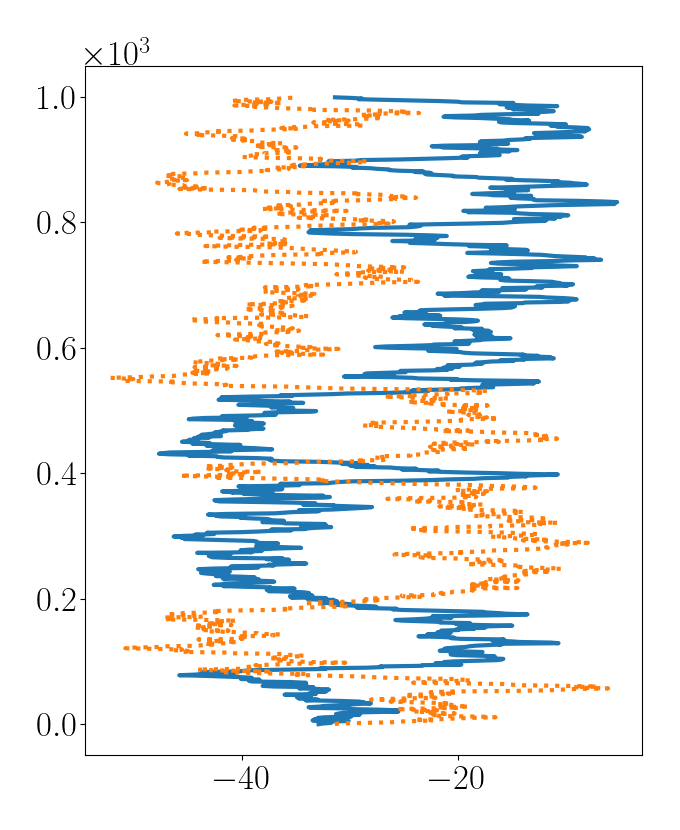

20


(100, 3, 1000)

In [113]:


P1 = np.load('Paths/HundredPaths1.npy')
P2 = np.load('Paths/HundredPaths2.npy')

fig, ax = plt.subplots(1,1)

# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
#for NP in range(len(P1[:,0,0])):
NP = 20
print(NP)
ax.plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
ax.plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')

np.shape(P1)

In [59]:
def ParityOfCrossings(Paths1,Paths2):
    '''
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return:Parity of crossings for each pair of paths

    '''
    return -(2*(NumberOfCrossings(Paths1,Paths2)%2)-1) 


def NumberOfCrossings(Paths1,Paths2):
    ''' Returns 
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return: Number of crossings for each pair of paths

    ''' 
    Sq = np.sign(Paths1[:,0,:]-Paths2[:,0,:])
    BitFunc = np.absolute(Sq[:,1:]-Sq[:,:-1])/2
    return np.sum(BitFunc, axis=1)
    

In [114]:
NumberOfCrossings(P1,P2)
ParityOfCrossings(P1,P2)
findPathsAction(P1,P2)
print('Action: Mean , STD  (Distribution is not taken into account yet)')
print(np.mean(findPathsAction(P1,P2)),' , ',np.std(findPathsAction(P1,P2)))
print('Number of Crossings: Mean , STD')
print(np.mean(NumberOfCrossings(P1,P2)),' , ',np.std(NumberOfCrossings(P1,P2)))
print('Count of Odd Crossings')
print(sum(ParityOfCrossings(P1,P2)==-1))
print('Count of Even Crossings')
print(sum(ParityOfCrossings(P1,P2)==1))

Action: Mean , STD  (Distribution is not taken into account yet)
4049.071020506987  ,  52.363258351267916
Number of Crossings: Mean , STD
5.65  ,  2.906458325866724
Count of Odd Crossings
37
Count of Even Crossings
63


In [92]:
ParityOfCrossings(P1,P2)==-1
oddargs = np.argwhere(ParityOfCrossings(P1,P2)==-1)
P1_odd = P1[oddargs[:,0],:,:]
P2_odd = P2[oddargs[:,0],:,:]

In [122]:

DeltaS = np.sum(findPathsAction(P1_odd,P2_odd))-np.sum(findPathsAction(P1,P2))
J = -DeltaS
DeltaS/100

-255064.9314350469

In [129]:
np.sum(findPathsAction(P1_odd,P2_odd))/4049.071020506987

np.sum(findPathsAction(P1,P2))/4049.071020506987
-(hbar/(tau*1000))*np.log(37/100)

654.4168463149332

In [116]:
#findPathsAction(P1_odd,P2_odd)/hbar #- np.sum(-findPathsAction(P1,P2)/hbar)
S = []
Paths1 = P1_odd
Paths2 = P2_odd
for NP in range(len(Paths1[:,0,0])):
    s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
    S.append(s)
S

[4052.974506848366,
 4159.324574175614,
 4071.175768081528,
 3966.9201355694795,
 4036.261775397248,
 4084.6819273186793,
 4061.1140239702727,
 4013.1009338009558,
 4088.0769977308128,
 4132.044903498997,
 4002.905463304566,
 4034.6228332941996,
 4074.6178383983483,
 4000.3694214826824,
 4061.8601467737562,
 4038.7602777620764,
 4001.421096431257,
 4183.64785324981,
 4077.704344690454,
 4056.3312322430656,
 4018.045149713453,
 4024.8770549255805,
 4000.793401266676,
 4014.2968522308624,
 4027.800749858919,
 4042.4403425453816,
 4026.4250472434087,
 4026.4274442071423,
 4043.428041888344,
 4033.8171840349996,
 4032.518600148977,
 4009.81601763331,
 4004.246544776336,
 4102.144557485469,
 4114.1285442979715,
 4087.797155279048,
 4035.2518740937453]

In [100]:
np.shape(P1_odd)


(37, 3, 1000)

<IPython.core.display.Javascript object>


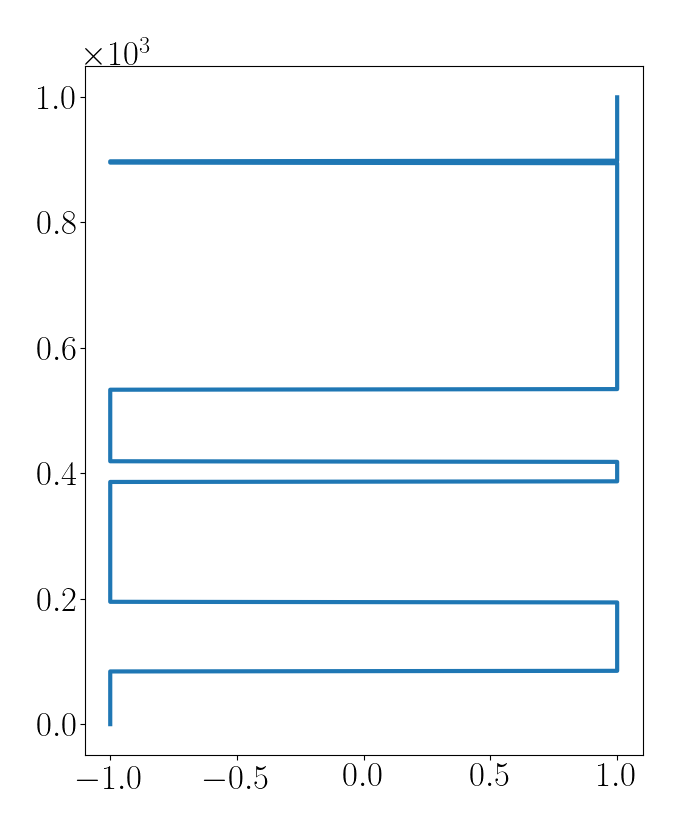

-1.0

In [68]:
NP = 20

fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
ax.plot( A  , range(len(P2[NP,0,:])))
ParityOfCrossings(P1,P2)[20]

<IPython.core.display.Javascript object>


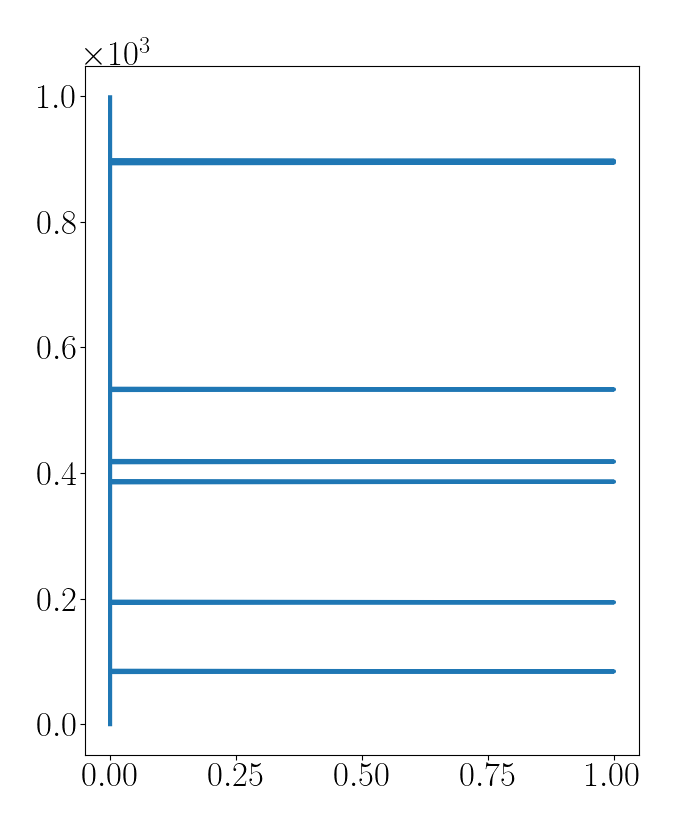

In [24]:
fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
ax.plot( np.absolute(A[1:]-A[:-1])/2  , range(len(P2[NP,0,:])-1))



In [25]:
sum(np.absolute(A[1:]-A[:-1])/2)

7.0